# CNN for CIFAR-10

In [0]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [0]:
import numpy as np

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

### Description

Classification of the CIFAR-10 dataset using using a convolutional neural network (CNN) and a multi-layer perceptron (MLP, for comparison).

### Content

1. Loading data
  1. Loading training and test datasets
  2. Splitting training and validation datasets
  3. Creating a data loader
2. Defining neural networks
  1. Multi-layer perceptron (MLP)
  2. Convolutional neural network (CNN)
3. Training the neural networks
4. Evaluation of the classifiers
  1. Performance on test set
  2. Comparison between MLP and CNN

### GPU

Training a convolutional neural network (CNN) can quickly become computationally expensive, especially for large images and a large number of convolutional filters. For this reason we should offload the forward pass and backpropagation to a graphic processing unit (GPU), if it is available. We can write general code that works both on a CPU and a GPU buy defining a `device`:

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Set

### CIFAR-10

The CIFAR-10 dataset is a benchmark dataset for computer vision containing 60000 images divided in 10 classe. The dataset is composed of different photographs of the following classes: airplane, automobile, bird, cat deer, dog, frog, horse, ship, truck. The images are $32 \times 32$ pixels and are composed of three channels (RGB).

### Loading the Dataset

As usual, we want to load the data into `torch.tensor`s and apply a transformation so that the data is normalised in order to reduce data skewness. We use the `transforms.Normalise` function in order to normalise our data; however CIFAR-10 images are RGB images and therefore the normalisation transformation should normalise each channel.

In [0]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Array to PyTorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalisation (mean and std)
    ]
)



Using the transformation we can now download the train and test dataset

In [7]:
# Download and load the training dataset
trainset = datasets.CIFAR10("data", download=True, train=True, transform=transform)

# Download and load the training dataset
testset = datasets.CIFAR10("data", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


The test dataset is used to test the model after training in order to evaluate its performance on previously unseen data. However, we also want to track the performance of the model during training. For this purpose we need a validation set, which we can create as a subset of of the training set. We can use `sklearn.model_selection.train_test_split` to split the training set indices in training and validation sets indices and use `torch.utils.data.sampler.SubsetRandomSampler` to sample elements randomly from a given list of indices (without replacement) in order to create training and validation batches.

In [0]:
# Number of training examples
n = len(trainset)

# Get indices for the training set and validation set
idx_train, idx_valid = train_test_split(np.arange(n), test_size=0.2, random_state=42)

# Define random samplers to sample elements randomly from a given list of indices
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_valid)

We can then combine a dataset and sampler into a `torch.utils.data.DataLoader`, which provides an iterable over the given dataset. Here we are doppring the last batch in order to ensure that all batches have the same dimension.

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler, drop_last=True)
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler, drop_last=True)

# Just shuffle inputs for testloader
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, drop_last=True)

Finally, we can define iterators to iterate over `tranloader`, `validloader` and `testloader` batches:

In [0]:
trainiter = iter(trainloader)
validiter = iter(validloader)
testiter = iter(testloader)

#### Visualizing Images and Labels

First, let's define a dictionary mapping labels (numbers from 0 to 9 denoting one of the 10 CIFAR-10 classes) to the acutal classes names:

In [11]:
label_to_name = { 
    i : name 
    for i, name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]) 
}

print(label_to_name)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


Then we can visualise a batch of images. PyTorch store images with in the `C x H x W`convention (where C is number of channels, H the image height and W the image width) while `matplotlib` uses the `H x W x C` convention. This means that we have to transpose our tensor from `C x H x W` to  `H x W x C`.

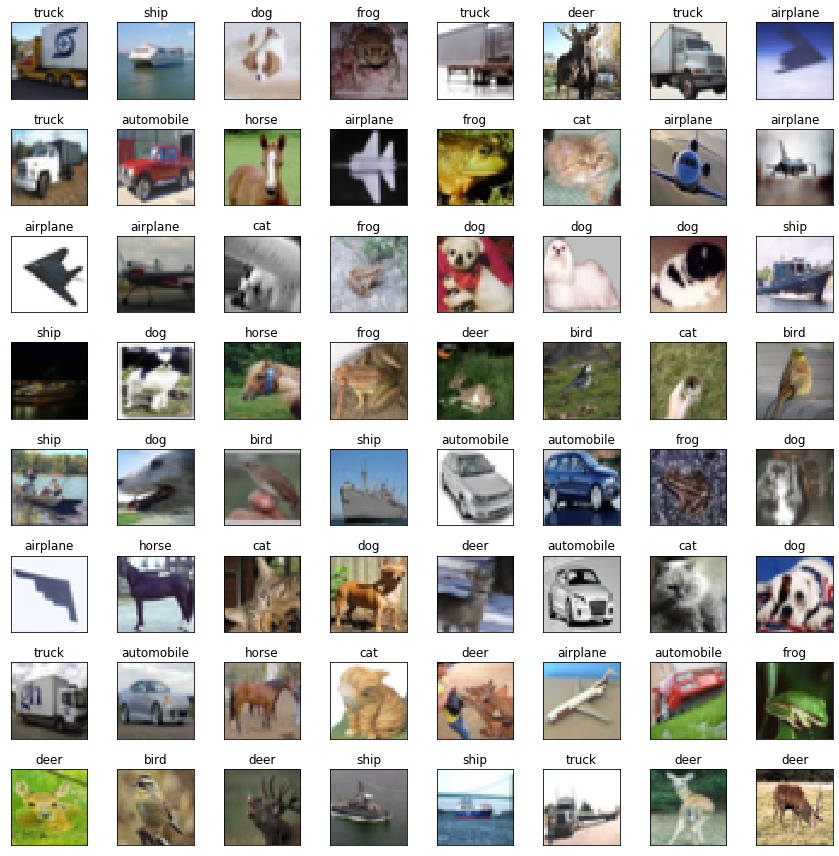

In [12]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze() * 0.5 + 0.5 

    # Transpose image from C x H x W to H x W x C
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    # Get name
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## CNN with PyTorch

Convolutional neural networks (CNNs) have been extremely succesfull in image classification tasks. Here we want to define such architecture by subclassing `nn.Module`. A simple CNN architecture consists of a first feature-detection part composed of 2D convolutional layers and pooling layers and a second classification part composed of fully connected layers. The following code defines a CNN with three convolutional layers with max pooling followed by two fully connected layers. Both convolutional and fully connected layers use a rectified linear unit (ReLU) activation function in order to add non-linearities to the network.

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 3 channels to 16 channels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        # 16 channels to 32
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # 32 channels to 34
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # Pooling without stride goes from n to n/2 pixels
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):

         # Input shape
        assert x.shape == (64, 3, 32, 32)

        # Apply first convolution and activation
        x = F.relu(self.conv1(x))

        # First convolution goes from 3 to 16 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 16, 32, 32)

        # Apply pooling
        x = self.pool(x)

        assert x.shape == (64, 16, 16, 16)

        # Apply second convolution and activation
        x = F.relu(self.conv2(x))

        # First convolution goes from 16 to 32 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 32, 16, 16)

        x = self.pool(x)

        assert x.shape == (64, 32, 8, 8)

        # Apply third convolution and activation
        x = F.relu(self.conv3(x))

        # First convolution goes from 32 to 64 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 64, 8, 8)

        x = self.pool(x)

        assert x.shape == (64, 64, 4, 4)

        # Flatten features for fully connected layers
        x = x.view(-1, 64 * 4 * 4)

        assert x.shape == (64, 64 * 4 * 4)

        x = F.relu(self.fc1(x))

        assert x.shape == (64, 512)

        x = F.log_softmax(self.fc2(x), dim=1)

        assert x.shape == (64, 10)

        return x

Once the model is defined we can create an instance and move it to the `device`:

In [14]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### Test Forward Pass

In order to check that our model definition works correctly, we can try to propagate on batch of images through the network. It is important to notice that the data from the `DataLoader` has to be moved to the `device` as well (since the model is now working on the `device`).  We can also plot the class probabilities of this untrained model:

In [0]:
def showclassp(images, labels, model, misclassified=False):
    """
    Plot class probabilities for a batch of images and labels.
    """
    
    from collections import namedtuple
    
    # Define named tuple for misclassified images
    # Clearer for printing, reporting batch index and true label
    Misclassified = namedtuple("Misclassified", "index true_label")
    
    # Defint a figure
    fig = plt.figure(figsize=(14,12))
    
    # List of missclassified systems
    failed = []
    
    # Compute predictions
    with torch.no_grad(): # Do not track gradients
            # Perform forward pass
            out = model(images)
            
            # Compute class probabilities
            # The model returns log-probabilities
            p = torch.exp(out).cpu().numpy()
    
    # Loop over images and labels in a batch
    for idx in range(64):
        
        # Create subplot
        ax = fig.add_subplot(8, 8, idx + 1, xticks=range(10), yticks=[0, 1])

        # Plot all class probabilities for given image
        for i in range(10):
            if labels[idx] == i:
                if labels[idx] == np.argmax(p[idx]):
                    plt.bar(i, p[idx,i], color="g")
                else:
                    plt.bar(i, p[idx,i], color="r")
                    
                    # Append misclassified sample
                    failed.append(Misclassified(idx, np.argmax(p[idx])))
            else:
                plt.bar(i, p[idx,i], color="k")
        plt.ylim([0,1.25])
        
        ax.set_xticklabels(label_to_name.values(), rotation=90, fontdict={"fontsize": 7.5})
        
        name = label_to_name[labels[idx].item()]
        ax.set_title(name, fontdict={"fontsize": 12})

    plt.tight_layout()
    plt.show()
    
    return failed if misclassified else  None

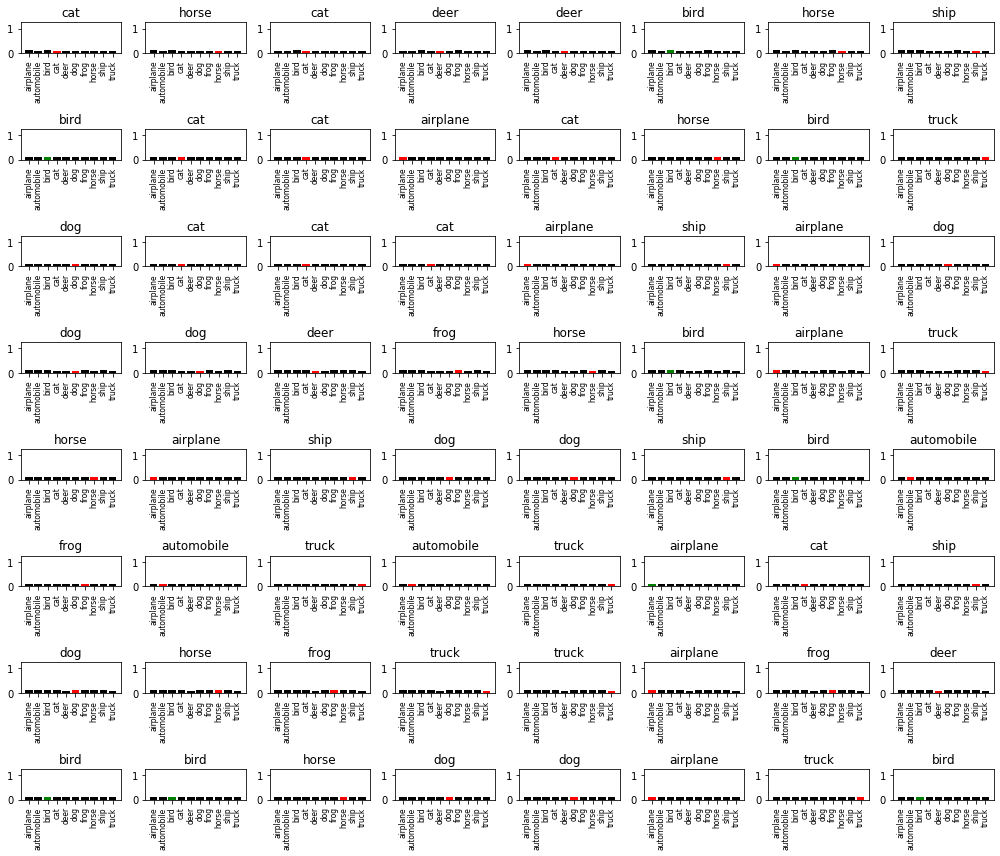

In [16]:
# Extract first batch of images
images, labels = next(trainiter)

# Move images and labels to the GPu
images, labels = images.to(device), labels.to(device)

# Perform forward propagation
# Show class probabilities
showclassp(images, labels, model)

As expected, the class probabilities look pretty much the same for each class and are close to $1/10$, since the parameters of the neural network are initialised at random.

### Training

In order to train the model we have to define a loss function. Since our model output pass through a `F.log_softmax` funcion, we need to use a negative log likelihood loss in order to obtain the same result of the cross-entropy loss applied to the raw outputs:

In [0]:
nll_loss = nn.NLLLoss()

Then we need to define an optimizer and link it to the model parameters. Here we use the [Adam optimizer](https://arxiv.org/abs/1412.6980).

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

Finally we can train our network. In order to speedup the training loop we can use the `torch.no_grad()` context manager so that expensive gradient computations are avoided during the validation phase.

In [0]:
def train(model, optimizer, loss_function, epochs=15, device=device):
    """
    Train a model by ooptimizing a loss_function using the given optimizer.
    Model and data are moved to the set device.
    """

    import time

    # Move model to device
    model.to(device)

    train_losses, valid_losses, accuracies = [], [], []

    # Loop over epochs
    for epoch in range(epochs):

        # Start epoch timer
        time_init = time.time()
        
        # Initialize total epoch loss
        epoch_loss = 0
        
        # Training
        for images, labels in trainloader:

            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
        
            # Initialize the gradients to zero
            optimizer.zero_grad()
            
            # Perform forward pass
            output = model(images)
            
            # Compute the loss
            loss = loss_function(output, labels)
            
            # Perform backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Accumulate total epoch loss
            epoch_loss += loss.item()
        else:
            valid_loss = 0
            accuracy = 0
            
            # Validation
            # No need totrack gradients during validation
            with torch.no_grad(): 
                for images, labels in validloader:

                    # Move data to GPU
                    images, labels = images.to(device), labels.to(device)
                    
                    # Perform forward pass
                    output = model(images)
                    
                    # Compute class probabilities
                    p = torch.exp(output)
                    
                    # Compute the loss
                    valid_loss += loss_function(output, labels).item()
                    
                    # Get probability and class of top prediction
                    top_p, top_c = p.topk(1, dim=1)

                    # Get truth table for the predicted classes
                    equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)

                    # Compute accuracy
                    accuracy += torch.mean(equals)
                    
            # Store losses
            train_losses.append(epoch_loss/len(trainloader))
            valid_losses.append(valid_loss/len(testloader))
            accuracies.append(accuracy.item()/len(testloader)*100)

            # Stop epoch timer
            time_end = time.time()
                
            print(f"--- Epoch {epoch+1:2} ---")
            print(f"Train Loss: {train_losses[-1]:.5f}")
            print(f"Test  Loss: {valid_losses[-1]:.5f}")
            print(f"Valid Accuracy: {accuracies[-1]:.2f}%")
            print(f"Time: {time_end - time_init:.3f} s")
    
    return train_losses, valid_losses, accuracies

In [20]:
# Define the number of training epochs
epochs = 15


train_losses, valid_losses, accuracies = train(model, optimizer, nll_loss, epochs, device)

--- Epoch  1 ---
Train Loss: 1.42684
Test  Loss: 1.10880
Valid Accuracy: 60.26%
Time: 11.799 s
--- Epoch  2 ---
Train Loss: 1.04854
Test  Loss: 0.99811
Valid Accuracy: 64.76%
Time: 11.593 s
--- Epoch  3 ---
Train Loss: 0.88009
Test  Loss: 0.89608
Valid Accuracy: 68.42%
Time: 11.589 s
--- Epoch  4 ---
Train Loss: 0.75658
Test  Loss: 0.90082
Valid Accuracy: 69.32%
Time: 11.622 s
--- Epoch  5 ---
Train Loss: 0.65105
Test  Loss: 0.91306
Valid Accuracy: 69.20%
Time: 11.467 s
--- Epoch  6 ---
Train Loss: 0.55722
Test  Loss: 0.90454
Valid Accuracy: 70.42%
Time: 11.491 s
--- Epoch  7 ---
Train Loss: 0.46989
Test  Loss: 1.00005
Valid Accuracy: 69.64%
Time: 12.057 s
--- Epoch  8 ---
Train Loss: 0.39724
Test  Loss: 1.12247
Valid Accuracy: 70.04%
Time: 11.968 s
--- Epoch  9 ---
Train Loss: 0.34043
Test  Loss: 1.19610
Valid Accuracy: 69.64%
Time: 11.898 s
--- Epoch 10 ---
Train Loss: 0.30118
Test  Loss: 1.30828
Valid Accuracy: 68.96%
Time: 11.792 s
--- Epoch 11 ---
Train Loss: 0.26397
Test  Loss: 1

Once training is finished we can plot the loss of both the training and the validation sets:

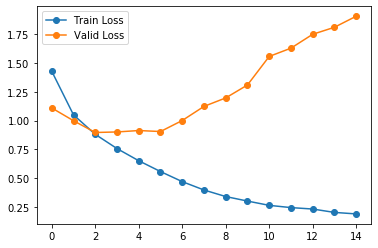

In [21]:
fig = plt.figure()
plt.plot(train_losses, "o-", label="Train Loss")
plt.plot(valid_losses, "o-", label="Valid Loss")
plt.legend()
plt.show()

We see that the validation loss decreases at first but then it starts increasing. This is caused by over-fitting: the model start to become well tuned for the training set (as shown by the decreasing training loss) but fails to generalise to the new samples contained in the validation set. 

Many techniques can be applied in order prevent overfitting:

*   Early stopping
*   Regularization
*   Dropouts
*   Data augmentation

## Multi-Layer Perceptron Baseline

The test accuracty of the CNN at the end of training is

In [22]:
print(f"Valid Accuracy: {accuracies[-1]:.2f}%")

Valid Accuracy: 68.40%


This is not that bad considering how challenging this dataset is compared to MNIST, considering that we did not perform any hiperparameter tuning and considering that we did not try to prevent overfitting in any way. 

To get a better idea of how difficult the dataset is, we can use a MLP model as baseline:

In [0]:
# Create a new Flatten layer to flatten images
# This allows to use nn.Sqeuential with out train function
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(-1, 3 * 32 * 32)

mlp = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

Before training, we have to define a new Adam optimizer and link it to the MLP parameters:

In [0]:
mlpoptimizer = optim.Adam(mlp.parameters(), lr=0.003)

Finally, we can use the helper function `train` to train the MLP in exactly the same way we trained the CNN:

In [25]:
_, _, mlp_accuracies = train(mlp, mlpoptimizer, nll_loss, epochs, device)

--- Epoch  1 ---
Train Loss: 1.77706
Test  Loss: 1.66517
Valid Accuracy: 41.26%
Time: 10.817 s
--- Epoch  2 ---
Train Loss: 1.59249
Test  Loss: 1.65621
Valid Accuracy: 42.05%
Time: 10.904 s
--- Epoch  3 ---
Train Loss: 1.50022
Test  Loss: 1.55217
Valid Accuracy: 45.81%
Time: 10.879 s
--- Epoch  4 ---
Train Loss: 1.42725
Test  Loss: 1.52493
Valid Accuracy: 47.18%
Time: 10.893 s
--- Epoch  5 ---
Train Loss: 1.36793
Test  Loss: 1.51650
Valid Accuracy: 47.02%
Time: 10.985 s
--- Epoch  6 ---
Train Loss: 1.31708
Test  Loss: 1.52730
Valid Accuracy: 48.56%
Time: 10.960 s
--- Epoch  7 ---
Train Loss: 1.25367
Test  Loss: 1.54975
Valid Accuracy: 49.00%
Time: 11.227 s
--- Epoch  8 ---
Train Loss: 1.20126
Test  Loss: 1.51922
Valid Accuracy: 49.41%
Time: 11.163 s
--- Epoch  9 ---
Train Loss: 1.15804
Test  Loss: 1.55885
Valid Accuracy: 49.23%
Time: 10.800 s
--- Epoch 10 ---
Train Loss: 1.11389
Test  Loss: 1.59145
Valid Accuracy: 49.27%
Time: 10.643 s
--- Epoch 11 ---
Train Loss: 1.07437
Test  Loss: 1

Over the same amout of epochs the MLP only reaches an accuracy of

In [26]:
print(f"Valid Accuracy: {mlp_accuracies[-1]:.2f}%")

Valid Accuracy: 51.14%


We see that the CNN performs better on this task. However, we didn't perform any hyperparameter optimization, which means that the accuracy of both models could be improved; With proper hyperparameter optimization one can show that CNNs perform way better than MLPs in image classification tasks.





## Testing the  Model

### Accuracy

In [27]:
def accuracy(model, testloader, loss_function, device=device):
    
    from collections import defaultdict
    
    test_loss = 0.0
    
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    model.eval()
    
    with torch.no_grad(): 
        for images, labels in testloader:

            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
                
            # Perform forward pass
            output = model(images)
                
            # Compute class probabilities
            p = torch.exp(output)
                
            # Compute the loss
            test_loss += loss_function(output, labels).item()
                
            # Get class of top prediction
            _, c = torch.max(p, dim=1) 
            
            correct = np.squeeze(c.eq(labels.data.view_as(c)).cpu().numpy())
            
            for i in range(64):
                label = labels.data[i].item()
                
                class_correct[label] += correct[i].item()
                class_total[label] += 1
           
    # Average test loss (per example)
    test_loss = test_loss/len(testloader.dataset)
    print(f"Test Loss: {test_loss:.5f}")
    
    total_correct = np.sum([c for _, c in class_correct.items()])
    total = np.sum([c for _, c in class_total.items()])
    
    accuracy = total_correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f} ({total_correct}/{total})\n")
    
    for i in range(10):
        accuracy = class_correct[i] / class_total[i] * 100
        print(f"{label_to_name[i]:12}: {accuracy:.2f} ({class_correct[i]:3}/{class_total[i]:4})")
    
accuracy(model, testloader, nll_loss)

Test Loss: 0.03046
Test Accuracy: 68.59 (6848/9984)

airplane    : 76.68 (766/ 999)
automobile  : 79.16 (790/ 998)
bird        : 55.26 (552/ 999)
cat         : 44.49 (444/ 998)
deer        : 69.87 (698/ 999)
dog         : 62.12 (620/ 998)
frog        : 74.25 (741/ 998)
horse       : 71.44 (713/ 998)
ship        : 80.16 (800/ 998)
truck       : 72.47 (724/ 999)


We see that the model performs particularly poorly for cats.

### Misclassified  Examples

We can see how the model performs on the test  set. Let's look at one batch of the test set:

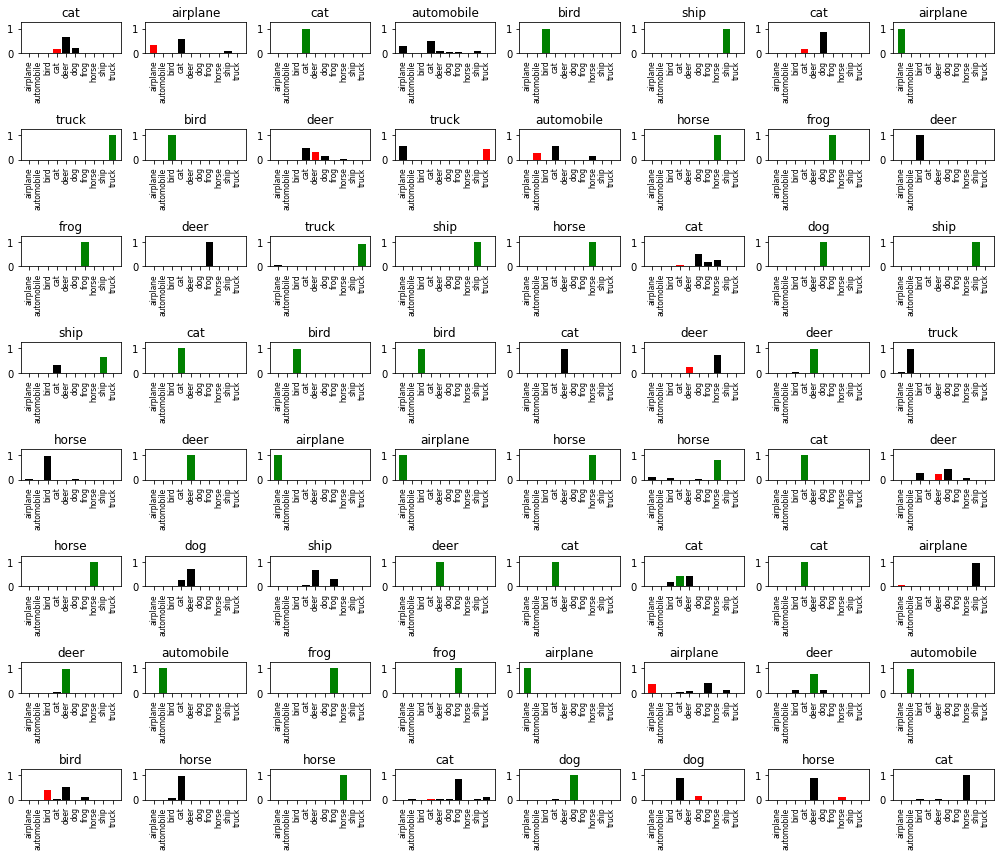

In [28]:
images, labels = next(testiter)

# Move data to device
images, labels = images.to(device), labels.to(device)

misclassified = showclassp(images, labels, model, misclassified=True)

We see that the CNN performs quite well in our image classification task, despite no hyperparameter optimization has been carried out.

### Misclassified Examples

The misclassified examples for this batch are the following:

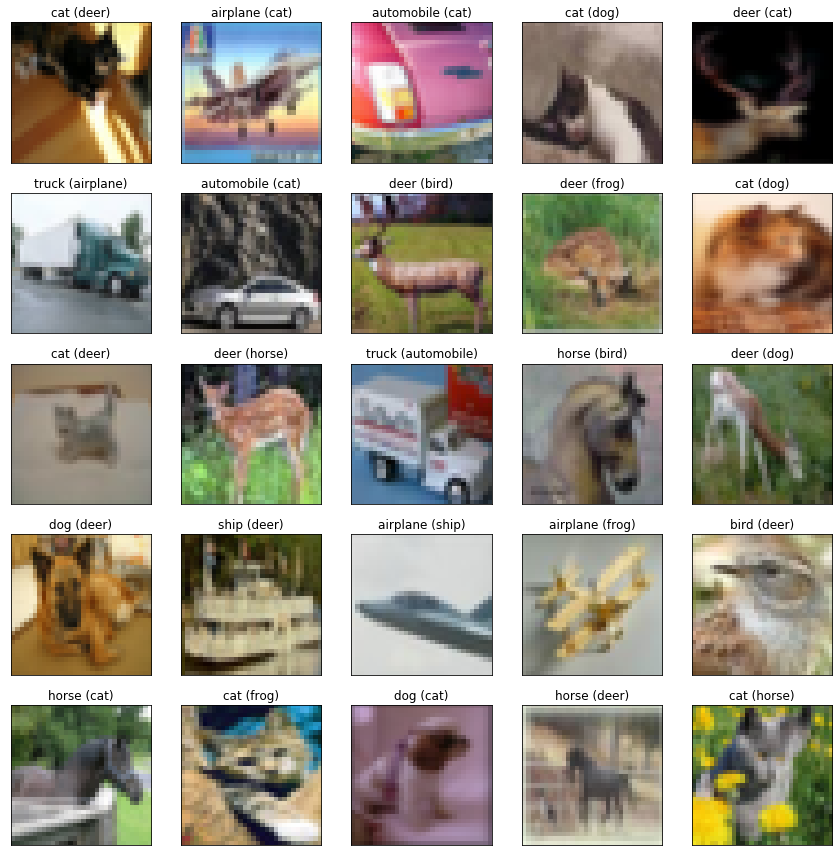

In [29]:
# Define grid size for subplot
n = np.ceil(np.sqrt(len(misclassified)))

fig = plt.figure(figsize=(12,12))
for i, (idx, true_label) in enumerate(misclassified):
    ax = fig.add_subplot(n, n, i + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].cpu().numpy().squeeze() * 0.5 + 0.5
    
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    name = label_to_name[labels[idx].item()]
    true_name = label_to_name[true_label]
    
    ax.set_title(f"{name} ({true_name})", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

###  Confusion Matrix

The confusion matrix is a great tool to assess the quality of a multi-class classifier and spot patterns in misclassified examples. To compute the confusion matrix we can predicted the classes of our test dataset with our model and use `sklearn.metrics.confusion_matrix` to get the confusion matrix:

In [0]:
def confusion(model, testloader):
    n = len(testloader) * 64
    
    y_pred = np.zeros(n)
    y_true =np.zeros(n)
    
    i = 0
    
    model.eval()
    
    with torch.no_grad(): 
        for images, labels in testloader:

            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
                
            # Perform forward pass
            output = model(images)
                
            # Compute class probabilities
            p = torch.exp(output)
                
            # Get class of top prediction
            p, c = torch.max(p, dim=1) 
            
            y_pred[i*64:i*64+64] = c.cpu().numpy()
            y_true[i*64:i*64+64] = labels.cpu().numpy()
            
            i += 1
            
    assert i == len(testloader)
    
    C = metrics.confusion_matrix(y_true, y_pred)
    
    for idx in range(10):
        C[idx,:] = C[idx,:] / np.sum(C[idx, :]) * 100
    
    return C

In [31]:
C = confusion(model, testloader)
print(C.diagonal())

[76 78 55 44 69 62 74 71 80 72]


Text(0, 0.5, 'True Label')

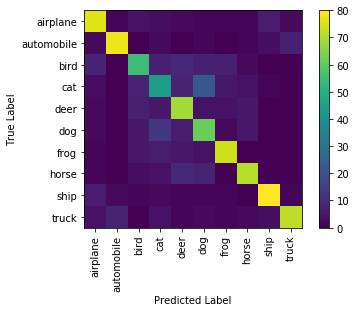

In [32]:
plt.imshow(C)
plt.xticks(range(10), label_to_name.values(), rotation=90)
plt.yticks(range(10), label_to_name.values())
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")